# Project 3 - Water Pump Clasificaiton

# Notes

**Things to add to my project - ideas from class**

Anything?


# Setup

In [1]:
from __future__ import print_function

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from __future__ import division
pd.set_option('display.width',5000)

In [3]:
import patsy

from sklearn import linear_model as lm
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Import - Training Data

This data is part of the Data Driven Competition

https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/


In [4]:
# 'Values' provided for each pump location - features

df_values = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Training set values.csv')
df_values.sample(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
25661,62314,0.0,2013-01-28,Mdrdp,1769,MDRDP,35.519182,-3.836887e+00,Kwa Lawei Surumbu,0,...,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump
45536,11050,0.0,2013-11-03,Oikos E.Afrika,1403,Community,36.868471,-3.133806e+00,Fanuel Akyoo,0,...,unknown,fluoride,fluoride,insufficient,insufficient,spring,spring,groundwater,communal standpipe multiple,communal standpipe
56208,72443,0.0,2011-08-01,Getdsc00,0,GETDSC00,0.000000,-2.000000e-08,M/Center,0,...,unknown,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe


In [5]:
# 'Labels' provided for each pump location - clasificaiton - what I am predicting

df_labels = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Training set labels.csv')
df_labels.sample(3)

,id,status_group
10036,10389,functional
21282,62117,non functional
53695,72062,non functional


# Data Import - Challenge Data

In [6]:
# 'Values' provided for each competition pump location - features

df_test_values = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/Test set values.csv')
df_test_values.sample(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
10807,70961,0.0,2013-02-02,Rwssp,0,DWE,32.561848,-3.649743e+00,Maendeleo,0,...,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
12934,33257,0.0,2013-02-15,Dwsp,0,DWE,0.000000,-2.000000e-08,Gisesa,0,...,monthly,soft,good,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump
3273,7914,0.0,2013-03-22,Adra,1134,Adra/Community,36.977734,-3.320390e+00,Fumo Lupio,0,...,unknown,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe


In [7]:
# 'Labels' I will provide for each pump location - clasificaiton

df_sub = pd.read_csv('/Users/amycurneen/ds/metis/metisgh/Metis-Curneen/3 - Water Pumps/Data Downloads/SubmissionFormat.csv')
df_sub.sample(3)

,id,status_group
7051,47663,predicted label
6880,7268,predicted label
1375,9381,predicted label


In [8]:
df_sub = df_sub.drop('status_group', axis = 1)

# Exploratory Data Analysis

## Colum descriptions

My goal is to predict the operating condition of a waterpoint for each record in the dataset. I was provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
    * 98 unique
* date_recorded - The date the row was entered
    * 365 unique
    * year - month - day
* funder - Who funded the well
    * 1897 unique
    * look at top ones?
* installer - Organization that installed the well
    * 2145 unique
    * DWE is main one - 10x closest other, 17k
* wpt_name - Name of the waterpoint if there is one
    * 37400 unique
    * look at top ones?
* num_private - (NO PROVIDED DESC)
    * 65 unique
    * USELESS FEATURE
* population - Population around the well
    * 1049 unique
    * a lot are zero
* public_meeting - True/False
    * 2 unique
* recorded_by - Group entering this row of data
    * 1 unique
    * all the same - USELESS FEATURE
* scheme_management - Who operates the waterpoint
    * 12 unique
* scheme_name - Who operates the waterpoint
    * 2696 unique
    * USELESS FEATURE
* permit - If the waterpoint is permitted
    * 2 unique
* construction_year - Year the waterpoint was constructed
    * 55 unique
    * third are 0 - USELESS FEATURE


* Geography
    * gps_height - Altitude of the well
        * numerical
    * longitude - GPS coordinate
        * numerical
    * latitude - GPS coordinate
        * numerical
    * basin - Geographic water basin
        * 9 unique
    * subvillage - Geographic location
        * 19287 unique
    * region - Geographic location
        * 21 unique
    * region_code - Geographic location (coded)
        * 27 unique
    * district_code - Geographic location (coded)
        * 20 unique
    * lga - Geographic location
        * 125 unique
    * ward - Geographic location
        * 2092 unique


* Extraction
    * extraction_type - The kind of extraction the waterpoint uses
        * 18 unique
        * Most descriptive of extraction
    * extraction_type_group - The kind of extraction the waterpoint uses
        * 13 unique
        * Parent of extraction_type
    * extraction_type_class - The kind of extraction the waterpoint uses
        * 7 unique
        * Parent of extraction_type_group


* Overhead
    * management - How the waterpoint is managed
        * 12 unique
    * management_group - How the waterpoint is managed
        * 5 unique
    * payment - What the water costs
        * 7 unique
        * same as payment type
    * payment_type - What the water costs
        * 7 unique
        * same as payment


* Water
    * water_quality - The quality of the water 
        * 3 unique
        * Subset of quality_group
    * quality_group - The quality of the water
        * 6 unique
        * Parent group of water_quality
    * quantity - The quantity of water
        * 5 unique
        * Same as quantity_group
    * quantity_group - The quantity of water
        * 5 unique
        * Same as quantity
    * source - The source of the water
        * 10 unique
    * source_type - The source of the water
        * 7 unique
        * Subset of source
    * source_class - The source of the water
        * 3 unique
        * Subset of source_type
    * waterpoint_type - The kind of waterpoint
        * 6 unique
        * Parent of waterpoint_type_group
    * waterpoint_type_group - The kind of waterpoint
        * 7 unique
        * Subset of waterpoint_type

## Various EDA

##### Status

In [9]:
# 3 Unique status present
df_labels.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

##### Review histograms of extraction data

* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses

18

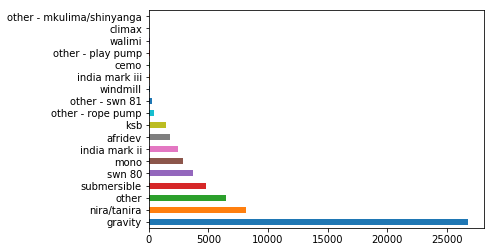

In [10]:
df_values.extraction_type.value_counts().plot('barh')
len(df_values.extraction_type.value_counts())

13

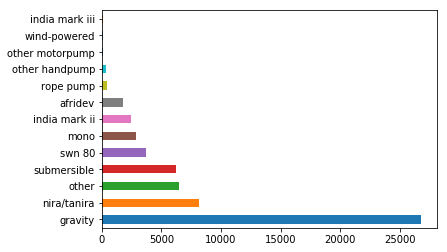

In [11]:
df_values.extraction_type_group.value_counts().plot('barh')
len(df_values.extraction_type_group.value_counts())

7

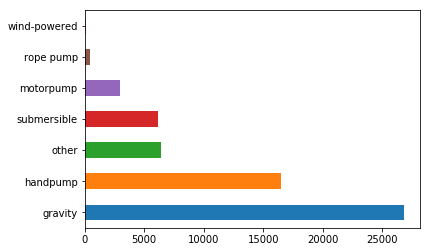

In [12]:
df_values.extraction_type_class.value_counts().plot('barh')
len(df_values.extraction_type_class.value_counts())

##### Other

In [13]:
# df_values.population.value_counts()

In [14]:
len(df_values.ward.value_counts())

2092

In [15]:
# len(df_values.management.value_counts())

In [16]:
# print(df_values.region.value_counts())
# print('Length: ',len(df_values.region.value_counts()))

In [17]:
#print(df_values.region_code.value_counts())
#print('Length: ',len(df_values.region_code.value_counts()))

In [114]:
df_values.amount_tsh.value_counts()

0.00         41639
500.00        3102
50.00         2472
1000.00       1488
20.00         1463
200.00        1220
100.00         816
10.00          806
30.00          743
2000.00        704
250.00         569
300.00         557
5000.00        450
5.00           376
25.00          356
3000.00        334
1200.00        267
1500.00        197
6.00           190
600.00         176
4000.00        156
2400.00        145
2500.00        139
6000.00        125
7.00            69
8000.00         61
750.00          59
40.00           59
10000.00        57
12000.00        51
             ...  
16000.00         2
16300.00         2
800.00           2
11000.00         2
590.00           2
520.00           2
26000.00         2
13000.00         2
9.00             1
170000.00        1
200000.00        1
900.00           1
0.25             1
53.00            1
350000.00        1
306.00           1
120000.00        1
26.00            1
59.00            1
60000.00         1
5400.00          1
70000.00    

In [19]:
#df_values.installer.value_counts()

# Test Train Split

In [20]:
# randomize data
# df_lables, df_values - combine and shuffle this data

df = pd.merge(df_labels,df_values,how = 'left')
df = df.sample(frac=1).reset_index(drop=True)

In [21]:
# Split back to X and y and then TTS
y = df[["id","status_group"]]
X = df.drop('status_group', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
X_train.shape

(47520, 40)

# Remove useless data features

# Decision Tree

In [49]:
# certain these are useless. see comments above

df_drop = df.drop(columns = ['recorded_by', 'num_private', 'scheme_name', 'construction_year', 'payment_type',
                 'quantity','wpt_name'])
df_drop.sample(3)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,...,management_group,payment,water_quality,quality_group,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
44127,33237,functional,0.0,2011-08-04,Unicef,0,UNICEF,30.707066,-2.630481,Lake Victoria,...,user-group,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump
28945,55076,functional,10000.0,2013-02-16,Tcrs,1494,TCRS,34.514912,-4.513811,Internal,...,user-group,pay annually,soft,good,enough,machine dbh,borehole,groundwater,hand pump,hand pump
6638,36704,non functional,0.0,2013-07-02,Rc,1202,RC,35.054561,-11.045177,Ruvuma / Southern Coast,...,user-group,unknown,soft,good,dry,spring,spring,groundwater,communal standpipe,communal standpipe


In [50]:
df_drop.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer', 'longitude', 'latitude', 'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward', 'population', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'water_quality', 'quality_group', 'quantity_group', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group'], dtype='object')

In [76]:
# remove things that are highly colinear

df_drop2 = df_drop.drop(columns = ['date_recorded', 'subvillage', 'region_code', 'district_code',
                                  'extraction_type_class', 'extraction_type', 'management',
                                  'water_quality', 'source_type', 'source_class', 'waterpoint_type',
                                  'ward','installer','funder','lga'])
df_drop2.sample(3)

,id,status_group,amount_tsh,gps_height,longitude,latitude,basin,region,population,public_meeting,scheme_management,permit,extraction_type_group,management_group,payment,quality_group,quantity_group,source,waterpoint_type_group
40465,34525,functional,0.0,184,38.791078,-5.104910,Pangani,Tanga,65,True,VWC,False,gravity,user-group,never pay,good,seasonal,spring,communal standpipe
57163,32747,functional,20.0,0,38.420814,-5.171566,Pangani,Tanga,1,True,VWC,True,afridev,user-group,pay per bucket,salty,seasonal,shallow well,hand pump
13912,1928,functional,0.0,0,36.306394,-6.112933,Wami / Ruvu,Dodoma,0,True,VWC,True,submersible,user-group,never pay,salty,enough,machine dbh,communal standpipe


In [75]:
df_drop2.columns

Index(['id', 'status_group', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'region', 'population', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_group', 'management_group', 'payment', 'quality_group', 'quantity_group', 'source', 'waterpoint_type_group'], dtype='object')

## Create DT on test-train-split

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [78]:
df.sample(3)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
24921,14177,functional,100.0,2013-03-17,0,57,0,39.102376,-6.950682,Kwa Michael Nyagoga,...,per bucket,salty abandoned,salty,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe
17612,16487,functional,0.0,2011-03-20,Sabemo,1654,Chamavita,38.343544,-4.751312,Kwa Mzee Scad,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
2169,50952,non functional,30.0,2011-08-04,Tasaf,101,DWE,39.035414,-5.001466,Msikitini,...,per bucket,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe multiple,communal standpipe


In [79]:
# try with a few less features first 

# feature_no_sel = df[['amount_tsh', 'date_recorded', 'funder', 'installer', 
#                    'wpt_name', 'num_private', 'subvillage', 'region', 
#                    'region_code', 'district_code', 'lga', 'ward', 'public_meeting', 'recorded_by', 
#                    'scheme_management', 'scheme_name', 'permit', 'construction_year', 'extraction_type', 
#                    'extraction_type_group', 'management', 'management_group', 'payment', 
#                    'payment_type', 'water_quality', 'quality_group', 'quantity_group', 'source', 
#                    'source_type', 'waterpoint_type','region_code', 
#                   'district_code','public_meeting','scheme_management']]

# feature_sel = df[['id', 'status_group', 'gps_height', 'longitude', 'latitude', 'basin',
#                   'extraction_type_class','payment','quantity','water_quality', 'source_class',
#                   'waterpoint_type_group','population','public_meeting','scheme_management']]

In [80]:
# feature_sel.sample(3)

In [81]:
# Change what I predict to 1,2,3

for i in range(len(df_drop2.status_group)):
    if df_drop2.status_group[i] == 'functional':
        df_drop2.at[i, 'status_group'] = 3
    elif df_drop2.status_group[i] == 'functional needs repair':
        df_drop2.at[i, 'status_group'] = 2
    else:
        df_drop2.at[i, 'status_group'] = 1

In [82]:
df_drop2=df_drop2.drop('id', axis=1)
df_drop2.sample(3)

,status_group,amount_tsh,gps_height,longitude,latitude,basin,region,population,public_meeting,scheme_management,permit,extraction_type_group,management_group,payment,quality_group,quantity_group,source,waterpoint_type_group
54899,3,50.0,96,39.088875,-6.990147,Wami / Ruvu,Dar es Salaam,250,NaN,WUG,False,submersible,user-group,pay per bucket,good,enough,machine dbh,communal standpipe
3901,3,5.0,1224,37.263746,-3.253608,Pangani,Kilimanjaro,30,True,Water Board,True,gravity,user-group,pay per bucket,good,enough,river,communal standpipe
34722,3,0.0,886,36.003696,-10.728770,Ruvuma / Southern Coast,Ruvuma,550,True,VWC,True,gravity,user-group,pay when scheme fails,good,seasonal,river,communal standpipe


In [85]:
# rearange columns
cols = df_drop2.columns.tolist()
cols = ['status_group',
 'amount_tsh',
 'gps_height',
 'longitude',
 'latitude',
 'population',
 'basin',
 'region',
 'public_meeting',
 'scheme_management',
 'permit',
 'extraction_type_group',
 'management_group',
 'payment',
 'quality_group',
 'quantity_group',
 'source',
 'waterpoint_type_group']
df_drop2 = df_drop2[cols]
df_drop2.sample(3)

,status_group,amount_tsh,gps_height,longitude,latitude,population,basin,region,public_meeting,scheme_management,permit,extraction_type_group,management_group,payment,quality_group,quantity_group,source,waterpoint_type_group
33133,3,0.0,0,33.472325,-3.422710,0,Internal,Shinyanga,True,WUG,False,nira/tanira,user-group,unknown,salty,enough,shallow well,hand pump
53237,1,600.0,1199,34.072045,-1.126688,500,Lake Victoria,Mara,NaN,Private operator,False,submersible,user-group,pay monthly,good,enough,lake,communal standpipe
39531,1,0.0,909,36.960722,-3.581010,200,Pangani,Manyara,True,NaN,True,other,user-group,unknown,salty,enough,shallow well,other


In [86]:
#create dummy features for applicabe

df_drop2 = pd.get_dummies(df_drop2,columns=list(df_drop2.columns[6:]))
df_drop2.sample(3)

,status_group,amount_tsh,gps_height,longitude,latitude,population,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,source_river,source_shallow well,source_spring,source_unknown,waterpoint_type_group_cattle trough,waterpoint_type_group_communal standpipe,waterpoint_type_group_dam,waterpoint_type_group_hand pump,waterpoint_type_group_improved spring,waterpoint_type_group_other
34371,1,0.0,1106,38.386947,-5.027831,100,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
4438,1,50.0,1399,35.606682,-7.685609,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
15151,1,50.0,-34,39.254046,-7.390371,1444,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [87]:
columns = list(df_drop2.columns)
df_drop2[columns[6:]] = df_drop2[columns[6:]].astype(int)
df_drop2[columns[0]] = df_drop2[columns[0]].astype(int)

In [94]:
y = df_drop2.status_group
X = df_drop2.drop('status_group', axis=1)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [96]:
decisiontree = DecisionTreeClassifier(random_state=0)
decisiontree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [97]:
decisiontree.score(X_test,y_test)

0.7502525252525253

## DT on competition datsa

In [112]:
df_test_values = df_test_values[cols[1:]]

KeyError: "['basin' 'extraction_type_class' 'payment' 'quantity' 'water_quality'\n 'source_class' 'waterpoint_type_group' 'public_meeting'\n 'scheme_management'] not in index"

In [99]:
# rearange columns
cols = df_test_values.columns.tolist()
cols = ['gps_height',
             'longitude',
             'latitude',
             'population',
             'basin',
             'extraction_type_class',
             'payment',
             'quantity',
             'water_quality',
             'source_class',
             'waterpoint_type_group',
             'public_meeting',
             'scheme_management']
df_test_values = df_test_values[cols]

In [100]:
df_test_values = pd.get_dummies(df_test_values,columns=list(df_test_values.columns[4:]))
df_test_values.sample(3)

,gps_height,longitude,latitude,population,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,...,scheme_management_Other,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority
13638,0,34.309933,-3.127140,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9553,0,32.909466,-4.177351,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
6591,1757,35.745452,-8.047754,200,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [101]:
a = [0] * len(df_test_values['gps_height'])
df_test_values['scheme_management_None'] = a
df_test_values.sample(3)

,gps_height,longitude,latitude,population,basin_Internal,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,basin_Lake Victoria,basin_Pangani,...,scheme_management_Parastatal,scheme_management_Private operator,scheme_management_SWC,scheme_management_Trust,scheme_management_VWC,scheme_management_WUA,scheme_management_WUG,scheme_management_Water Board,scheme_management_Water authority,scheme_management_None
480,1679,37.953495,-4.415925,45,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
471,1726,36.804014,-3.316737,56,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
7445,1935,34.225052,-9.421434,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [102]:
columns = list(df_test_values.columns)
df_test_values[columns[4:]] = df_test_values[columns[4:]].astype(int)
df_test_values[columns[0]] = df_test_values[columns[0]].astype(int)

## Apply to competition data

In [103]:
df_test_labels = decisiontree.predict(df_test_values)

ValueError: Number of features of the model must match the input. Model n_features is 103 and input n_features is 63 

In [104]:
df_test_labels.shape

NameError: name 'df_test_labels' is not defined

In [ ]:
df_sub['status_group'] = df_test_labels

In [ ]:
df_sub['status_group'] = df_sub['status_group'].astype(str)

for i in range(len(df_sub.status_group)):
    if df_sub.status_group[i] == '3':
        df_sub.at[i, 'status_group'] = 'functional'
    elif df_sub.status_group[i] == '2':
        df_sub.at[i, 'status_group'] = 'functional needs repair'
    else:
        df_sub.at[i, 'status_group'] = 'non functional'
df_sub.sample(3)

In [ ]:
df_sub.status_group.value_counts()

In [ ]:
df_sub.to_csv('./Submissions/decisionTree3.csv',index=False)

## Ranking

<table>
  <tr>
    <th>Best</th>
    <th>Current Rank</th>
    <th>Competitors</th>
    <th>Time</th>
  </tr>
  <tr>
    <td>0.6449</td>
    <td>1309</td>
    <td>5059</td>
    <td>May 7, 2018, 11:50 p.m.</td>
  </tr>
</table>

## Random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth = 4,random_state=0)
clf.fit(X_train, y_train)

In [ ]:
print(clf.feature_importances_)

In [ ]:
df_test_labels2 = clf.predict(df_test_values)

In [ ]:
df_sub['status_group'] = df_test_labels2

In [ ]:
df_sub['status_group'] = df_sub['status_group'].astype(str)

for i in range(len(df_sub.status_group)):
    if df_sub.status_group[i] == '3':
        df_sub.at[i, 'status_group'] = 'functional'
    elif df_sub.status_group[i] == '2':
        df_sub.at[i, 'status_group'] = 'functional needs repair'
    else:
        df_sub.at[i, 'status_group'] = 'non functional'
df_sub.sample(3)

In [ ]:
df_sub.status_group.value_counts()

In [ ]:
df_sub.to_csv('./Submissions/decisionTree2.csv',index=False)

## Ranking

<table>
  <tr>
    <th>Best</th>
    <th>Current Rank</th>
    <th>Competitors</th>
    <th>Time</th>
  </tr>
  <tr>
    <td>0.6988</td>
    <td>1276</td>
    <td>5059</td>
    <td>May 8, 2018, 12:13 a.m.</td>
  </tr>
</table>

# Appendix

## A

In [ ]:
columns = list(feature_sel.columns)
feature_sel[columns[5:]] = feature_sel[columns[5:]].astype(int)
feature_sel[columns[0]] = feature_sel[columns[0]].astype(int)

In [ ]:
feature_sel = feature_sel.sample(frac=1).reset_index(drop=True)
y = feature_sel.status_group
X = feature_sel.drop('status_group', axis=1)

from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.84)

In [ ]:
X_train.head(1)

## Adjust competition data

In [ ]:
df_test_values = df_test_values[['gps_height', 'longitude', 'latitude', 'basin',
                  'extraction_type_class','payment','quantity','water_quality', 'source_class',
                  'waterpoint_type_group','population','public_meeting','scheme_management']]

In [ ]:
# rearange columns
cols = df_test_values.columns.tolist()
cols = ['gps_height',
             'longitude',
             'latitude',
             'population',
             'basin',
             'extraction_type_class',
             'payment',
             'quantity',
             'water_quality',
             'source_class',
             'waterpoint_type_group',
             'public_meeting',
             'scheme_management']
df_test_values = df_test_values[cols]

In [ ]:
a = [0] * len(df_test_values['gps_height'])

In [ ]:
df_test_values = pd.get_dummies(df_test_values,columns=list(df_test_values.columns[4:]))
df_test_values.sample(5)

In [ ]:
columns = list(feature_sel.columns)
feature_sel[columns[5:]] = feature_sel[columns[5:]].astype(int)
feature_sel[columns[0]] = feature_sel[columns[0]].astype(int)

In [ ]:
df_test_values['scheme_management_None'] = a
df_test_values.head(10)

In [ ]:
list(set(X_train.columns)-set(df_test_values.columns))

##  B

In [ ]:
from __future__ import print_function

import numpy as np
import pandas as pd

from IPython.display import Image

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn import svm

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
pd.Series(y_train).value_counts()

## Principle Component Analysis

In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)

In [ ]:
pcafeatures_train = pca.transform(X_train)

In [ ]:
from itertools import cycle

In [ ]:
# def plot_PCA_2D(data, target, target_names):
#     colors = cycle(['r','g','b'])
#     target_ids = range(len(target_names))
#     plt.figure()
#     for i, c, label in zip(target_ids, colors, target_names):
#         plt.scatter(data[target == i, 0], data[target == i, 1],
#                    c=c, label=label)
#     plt.legend()

In [ ]:
# plot_PCA_2D(pcafeatures_train, target=y_train, target_names=digits.target_names)

## Fitting Linear and RBF SVM Models

In [ ]:
# fit linear model
model_svm = svm.SVC(kernel='rbf',probability=False,cache_size=2000)
model_svm.fit(X_train, y_train)

In [ ]:
# predict out of sample
y_pred = model_svm.predict(X_test)

In [ ]:
# check accuracy
accuracy_score(y_test,y_pred)

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred)

In [ ]:
# fit rbf model
# model_svm2 = svm.SVC(kernel='rbf', gamma = 0.001)
# model_svm2.fit(X_train, y_train)

In [ ]:
# predict out of sample
y_pred2 = model_svm2.predict(X_test)

In [ ]:
# check accuracy
accuracy_score(y_test,y_pred2)

In [ ]:
# confusion matrix
confusion_matrix(y_test,y_pred2)

## C

Extra code from class to utilize

In [ ]:
df.age=df.age.fillna(df.age.mean())

In [ ]:
y,X=dmatrices('survived~ pclass +age+sibsp+parch+fare',data=df,return_type='dataframe')

In [ ]:
# Generate a confusion matrix plot: 

def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Could be a typical function for classifying:

def train_score(classifier,x,y):
    xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(x, y, test_size=0.2, random_state=1234)
    ytrain=np.ravel(ytrain)
    clf = classifier.fit(xtrain, ytrain)
    # accuracy for test & train:
    train_acc=clf.score(xtrain, ytrain)
    test_acc=clf.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = clf.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[0, 0] / (conf[0, 0] + conf[1, 0])))
    print ("Recall:                 %0.2f"% (conf[0, 0] / (conf[0, 0] + conf[0, 1])))
    
    cm=confusion_matrix(y_true, y_pred, labels=None)
    
    plt.figure()
    plot_confusion_matrix(cm)

In [ ]:
log_clf=LogisticRegression()
train_score(log_clf,X,y)

In [ ]:
# What about ROC ? 

from sklearn.metrics import roc_curve, auc

xtrain, xtest, ytrain, ytest = cross_validation.train_test_split(X, y, test_size=0.2, random_state=1234)
log = LogisticRegression()
log.fit(xtrain,np.ravel(ytrain))
y_score=log.predict_proba(xtest)[:,1]

fpr, tpr,_ = roc_curve(ytest, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

In [ ]:
tpr

####  Cost Benefit Example: 

We can also optimize our models based on specific costs associated with our classification errors; here we will use specific dollar amounts as weights.

Let's say we were developing a classification model for Aircraft Delay prediction.  For this example let's assume that a true positive would 
lead to a cost savings of 2160 dollars, a false negative would cost us 2900 dollars a false positive would cost 750 dollars.  

cb = np.array([[2160, -750.0], [-2900, 0]])  

Expected_Value = #TPs(2160) - #FNs(2900) -#FPs(750)  